In [ ]:
!nvidia-smi

In [ ]:
pip install -U spacy[cuda101]

In [ ]:
! python -m spacy download en_core_web_sm

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
import json

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from scipy.sparse import coo_matrix, save_npz, load_npz


In [ ]:
spacy.prefer_gpu()

In [72]:
with open('/content/drive/MyDrive/USF/spring2/msds626/finalproject/jeopardy.json') as f:
    data_json = json.load(f)

data = pd.DataFrame(data_json)

# create question list
questions = data['question'].values


,category,air_date,question,value,answer,round,show_number
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",$200,Copernicus,Jeopardy!,4680
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,$200,Jim Thorpe,Jeopardy!,4680
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,$200,Arizona,Jeopardy!,4680
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",$200,McDonald\'s,Jeopardy!,4680
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",$200,John Adams,Jeopardy!,4680
5,3-LETTER WORDS,2004-12-31,"'In the title of an Aesop fable, this insect s...",$200,the ant,Jeopardy!,4680
6,HISTORY,2004-12-31,'Built in 312 B.C. to link Rome & the South of...,$400,the Appian Way,Jeopardy!,4680
7,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 8: 30 steals for the Birmingham Barons; 2...,$400,Michael Jordan,Jeopardy!,4680
8,EVERYBODY TALKS ABOUT IT...,2004-12-31,"'In the winter of 1971-72, a record 1,122 inch...",$400,Washington,Jeopardy!,4680
9,THE COMPANY LINE,2004-12-31,'This housewares store was named for the packa...,$400,Crate & Barrel,Jeopardy!,4680


In [47]:
nlp = spacy.load("en_core_web_sm")

# add some stop words identified in questions
nlp.vocab["this"].is_stop = True
nlp.vocab["www"].is_stop = True
nlp.vocab["http"].is_stop = True
nlp.vocab["href"].is_stop = True
nlp.vocab["media"].is_stop = True
nlp.vocab["jpg"].is_stop = True
nlp.vocab["com"].is_stop = True


In [49]:
import re
import string
from tqdm import tqdm

def process(text):
    text = text.lower()
    text = re.sub('[' + string.punctuation + '0-9\\r\\t\\n]', ' ', text)
    text = " ".join([token.lemma_ for token in nlp(text) if token.is_stop is False and (token.pos_ is 'PROPN' or token.pos_ is 'NOUN')])
    words_list = text.split(' ')
    words_list = [w for w in words_list if len(w) > 2] # ignore a, an, to, at, be, ...
    processed_text = " ".join(words_list)

    return processed_text

processed_questions = []
for c in tqdm(questions):
    processed_questions.append(process(c))

In [75]:
with open('question_processed.txt', 'w') as filehandle:
    for p in processed_questions:
        filehandle.write('%s\n' % p)

## NMF

In [88]:
# only consider first 8000 frequent words in the questions
n_features = 8000

tfidf_vectorizer = TfidfVectorizer(max_features=n_features) #max_features=n_features
tfidf = tfidf_vectorizer.fit_transform(processed_questions)

print(f'After transform the questions into tfidf matrix, it has {tfidf.shape[0]} question and {tfidf.shape[1]} number of vocabulary')

After transform the questions into tfidf matrix, it has 216930 question and 8000 number of vocabulary


In [113]:
# assign number of topics
n_components = 15

# apply NMF to tfidf matrix
nmf = NMF(n_components=n_components, random_state=0, alpha=.1, l1_ratio=.5).fit(tfidf) #
nmf_output = nmf.fit_transform(tfidf)

print(f'The tfidf matrix was decomposed into document-topic matrix with the \
shape of {nmf_output.shape} and topic-term matrix with the shape of {nmf.components_.shape}')

The tfidf matrix was decomposed into document-topic matrix with the shape of (216930, 15) and topic-term matrix with the shape of (15, 8000)


In [128]:
def show_topics(vectorizer=tfidf_vectorizer, model=nmf, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in model.components_:
        # argsort sort the array in ascending order and return the ordered index, 
        # top n_words but the weight is in ascending order
        top_keyword_locs = (topic_weights).argsort()[-n_words:]
        top_keyword_locs = top_keyword_locs[::-1]
        keywords_weight = list(zip(keywords.take(top_keyword_locs), (topic_weights).take(top_keyword_locs)))
        topic_keywords.append(keywords_weight)
    return topic_keywords

In [146]:
topic_keywords = show_topics(vectorizer=tfidf_vectorizer, model=nmf, n_words=20) 

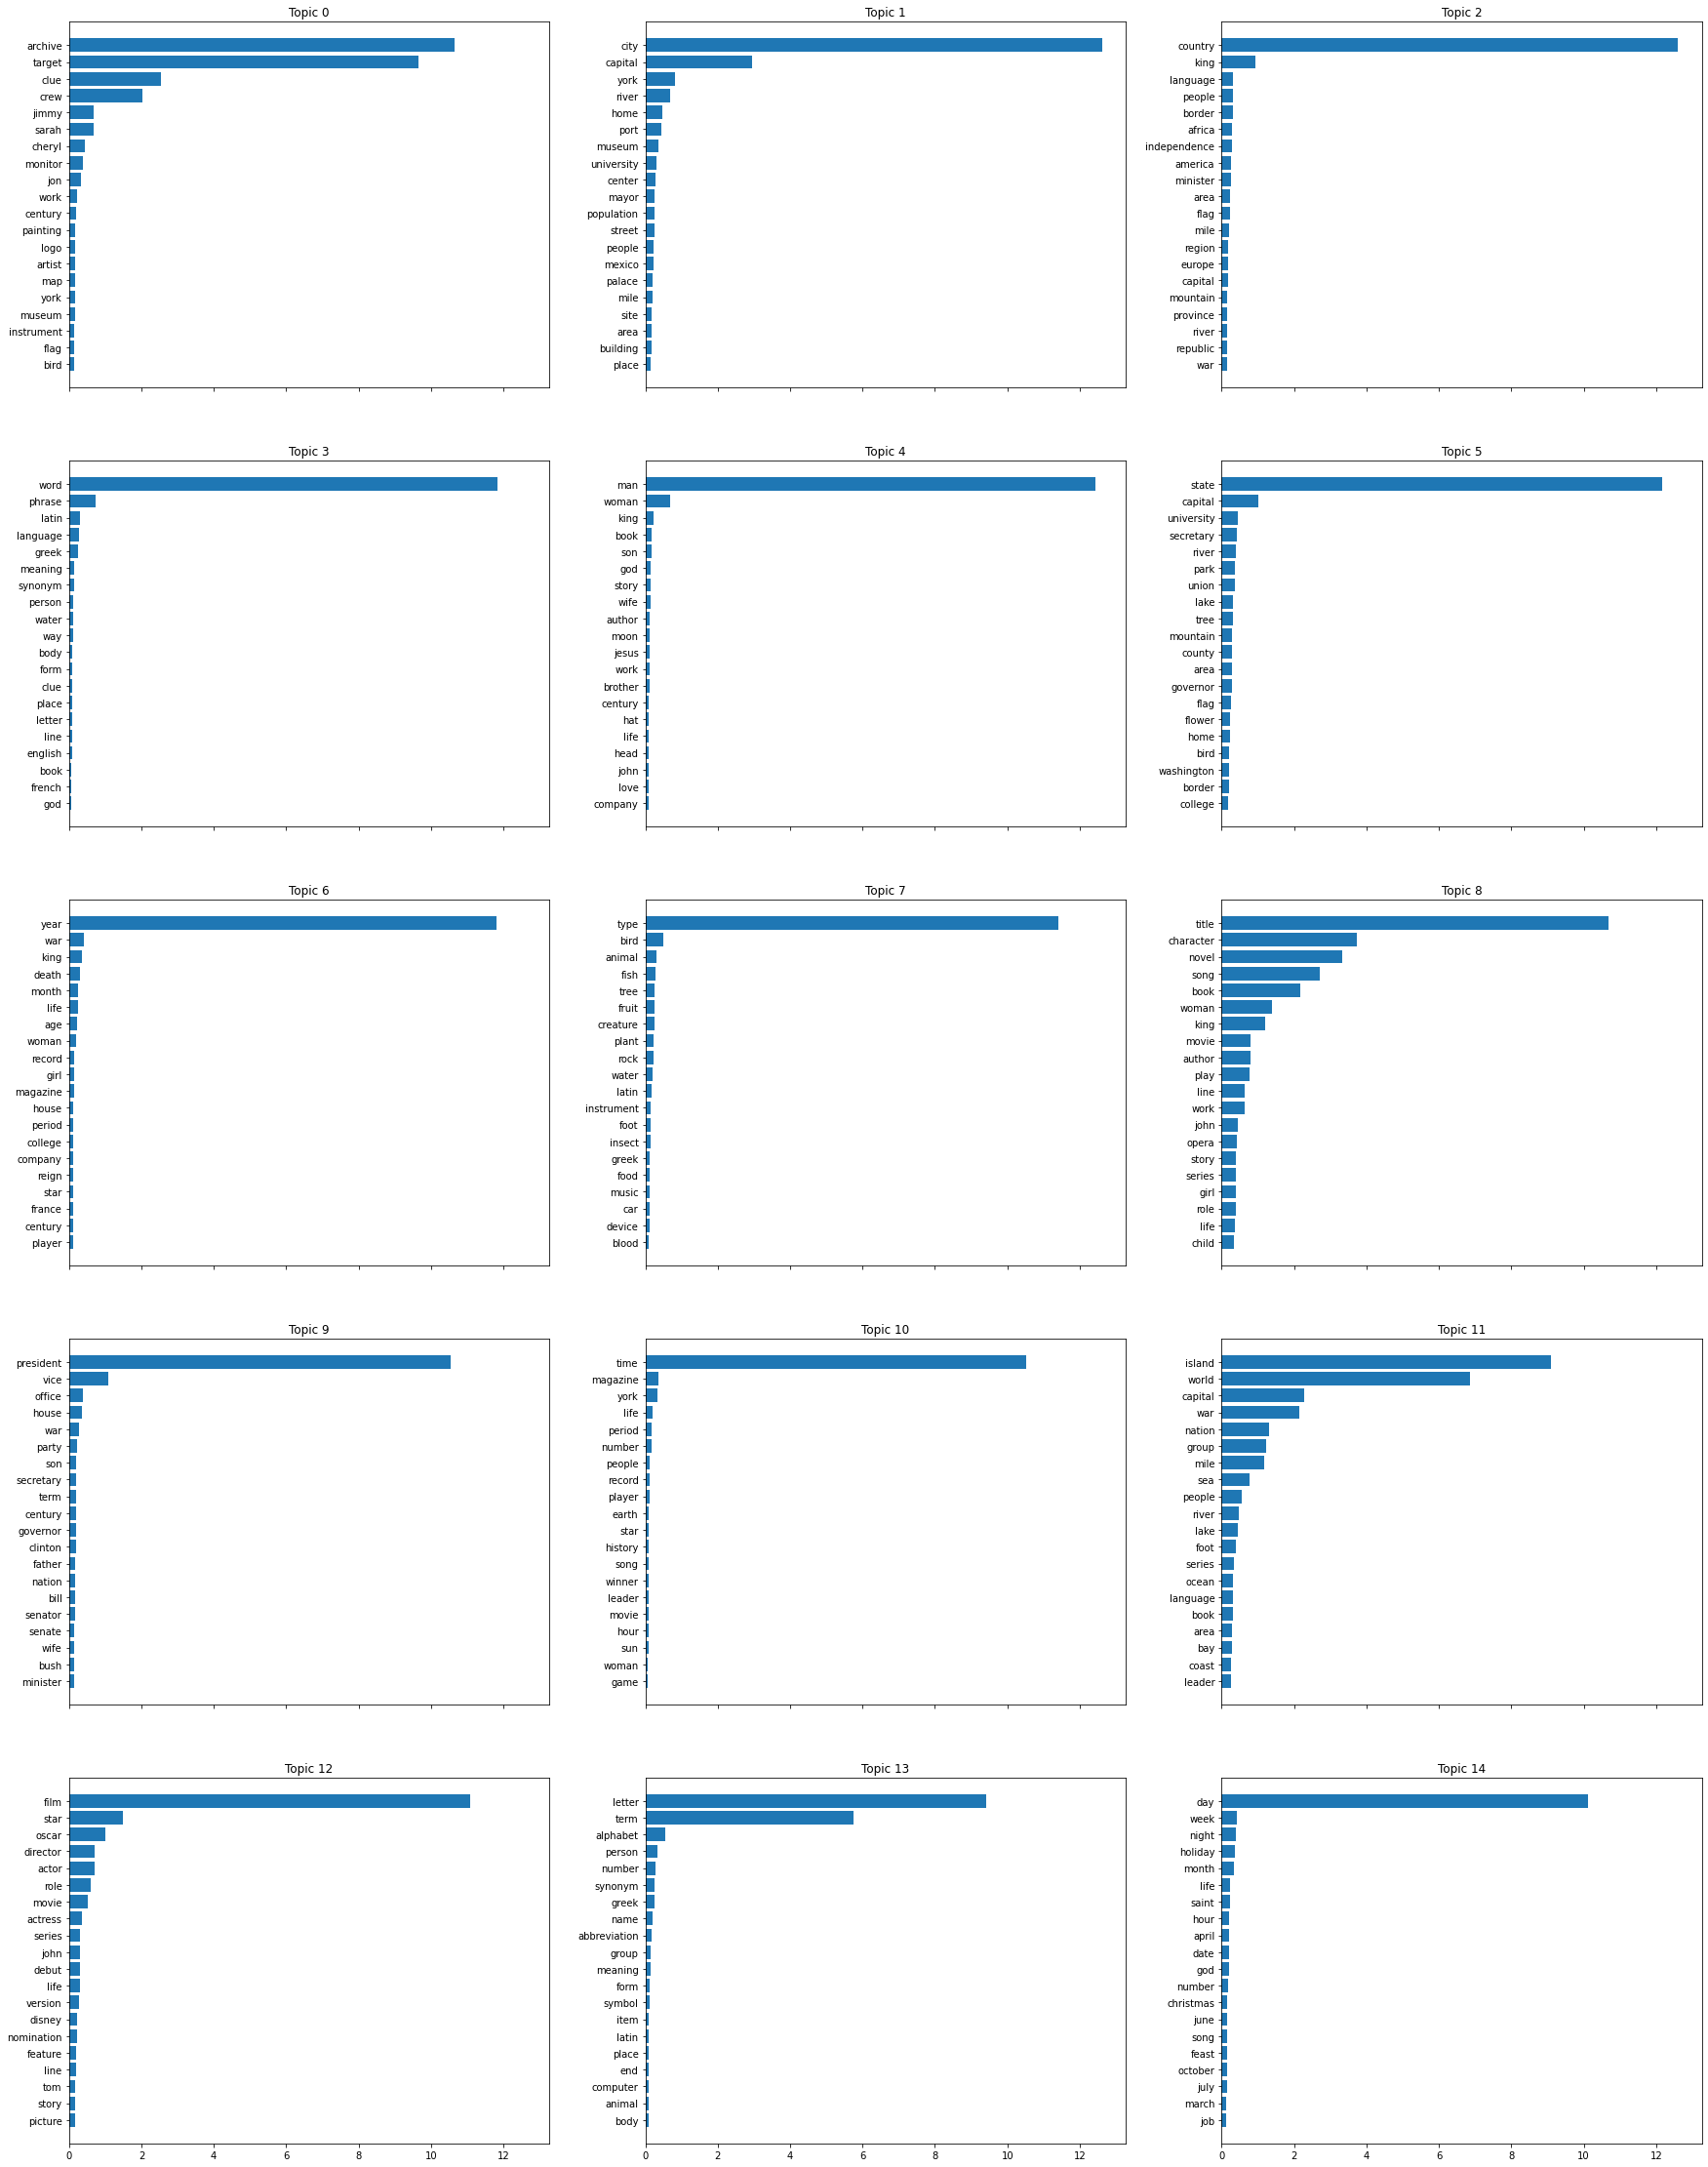

In [175]:
n_words=20

fig, axes = plt.subplots(5, 3, figsize=(30, 40), sharex=True)
axes = axes.flatten()
y_pos = range(n_words, 0, -1)
for i in range(n_components): #range(n_cluster):
    axes[i].barh(y_pos, [j[1] for j in topic_keywords[i]])
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels([j[0] for j in topic_keywords[i]])
    axes[i].set_title(f'Topic {i}')

In [176]:
np.argmax(nmf_output[0])

6

## LDA

In [154]:
n_features = 8000

vectorizer = CountVectorizer(max_features = n_features)
data_vectorized = vectorizer.fit_transform(processed_questions)
print(f'After transform the questions into word count matrix, it has {data_vectorized.shape[0]} question and {data_vectorized.shape[1]} number of vocabulary')

After transform the questions into word count matrix, it has 216930 question and 8000 number of vocabulary


In [155]:
lda_model = LatentDirichletAllocation(n_components=15, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )

lda_output = lda_model.fit_transform(data_vectorized)

print(f'The tfidf matrix was decomposed into document-topic matrix with the \
shape of {lda_output.shape} and topic-term matrix with the shape of {lda_model.components_.shape}')

The tfidf matrix was decomposed into document-topic matrix with the shape of (216930, 15) and topic-term matrix with the shape of (15, 8000)


In [156]:
topic_keywords_lda = show_topics(vectorizer=vectorizer, model=lda_model, n_words=20)

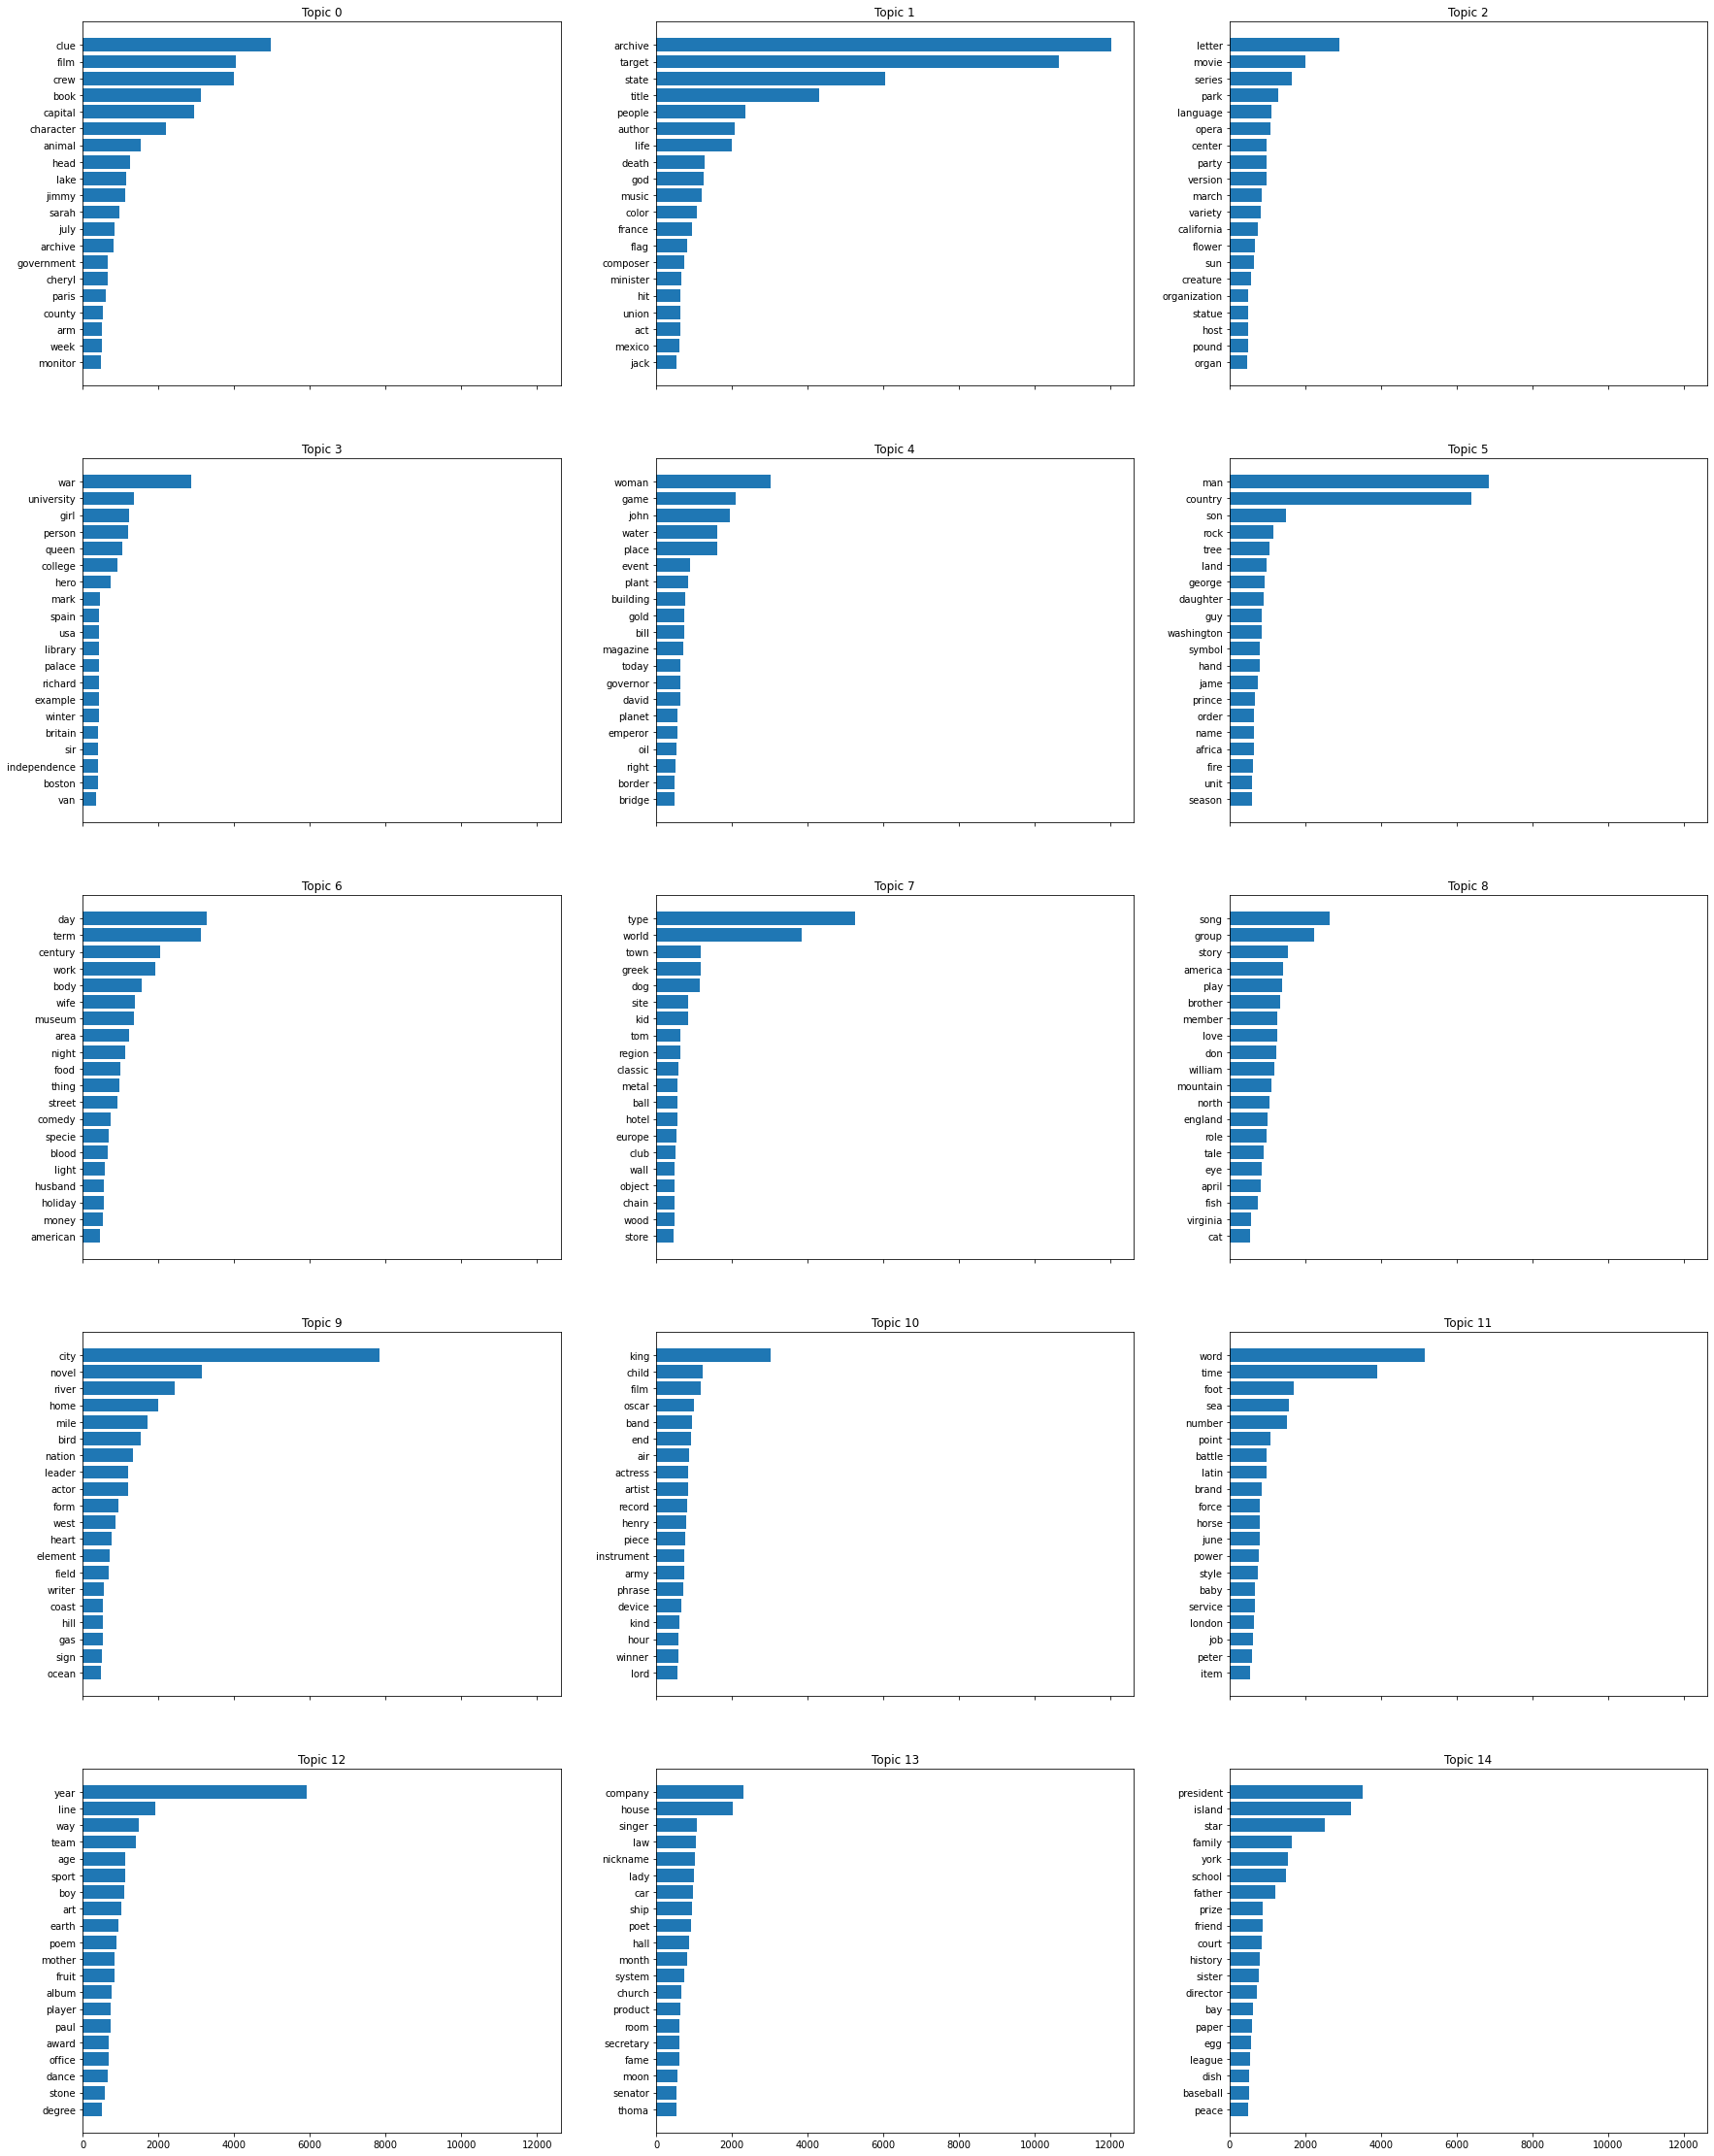

In [157]:
n_words=20

fig, axes = plt.subplots(5, 3, figsize=(30, 40), sharex=True)
axes = axes.flatten()
y_pos = range(n_words, 0, -1)
for i in range(n_components): #range(n_cluster):
    axes[i].barh(y_pos, [j[1] for j in topic_keywords_lda[i]])
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels([j[0] for j in topic_keywords_lda[i]])
    axes[i].set_title(f'Topic {i}')

In [177]:
np.argmax(lda_output[0])

1